In [65]:
import numpy as np
from scipy.signal import find_peaks, savgol_filter
import matplotlib.pyplot as plt
import pandas as pd
from hampel import hampel
from chusai import ReadWave

CSI = np.load('CSI_s_0.npy')
Wave = ReadWave('/data/hdr/breath_detect/chusai_data/TestData/TestBreathWave001.txt')
Wave = Wave[0]['Wave']

(Nrx, Ntx, Nsc, Nt) = CSI.shape
print(Nrx, Ntx, Nsc, Nt)

fstart = 5300.0 * 1e6
fend = 5336.25 * 1e6
Tdur = 30.059486

# fs = (fend + fstart) / 2
fs = Nt / Tdur
BPMresol = 0.1
resol = BPMresol / 60 # 要分辨出0.1BPM，需要的频率分辨率
Ndft = int(fs / resol) # DFT点数
print(Ndft)

breathEnd = 0.7 # 呼吸最高频率
dftSize = int(breathEnd / resol) # DFT宽度
print(dftSize)

# CSI_hampel = np.zeros((Nrx, Ntx, Nsc, Nt), dtype=np.complex64)
# # Perform Hampel filtering on the time domain of CSI
# for rx in range(Nrx):
#     for tx in range(Ntx):
#         for sc in range(Nsc):
#             CSI_hampel[rx][tx][sc] = hampel(CSI[rx][tx][sc], window_size=5, n_sigmas=3)


3 1 30 1500
29940
419


In [66]:
from sklearn.preprocessing import MinMaxScaler

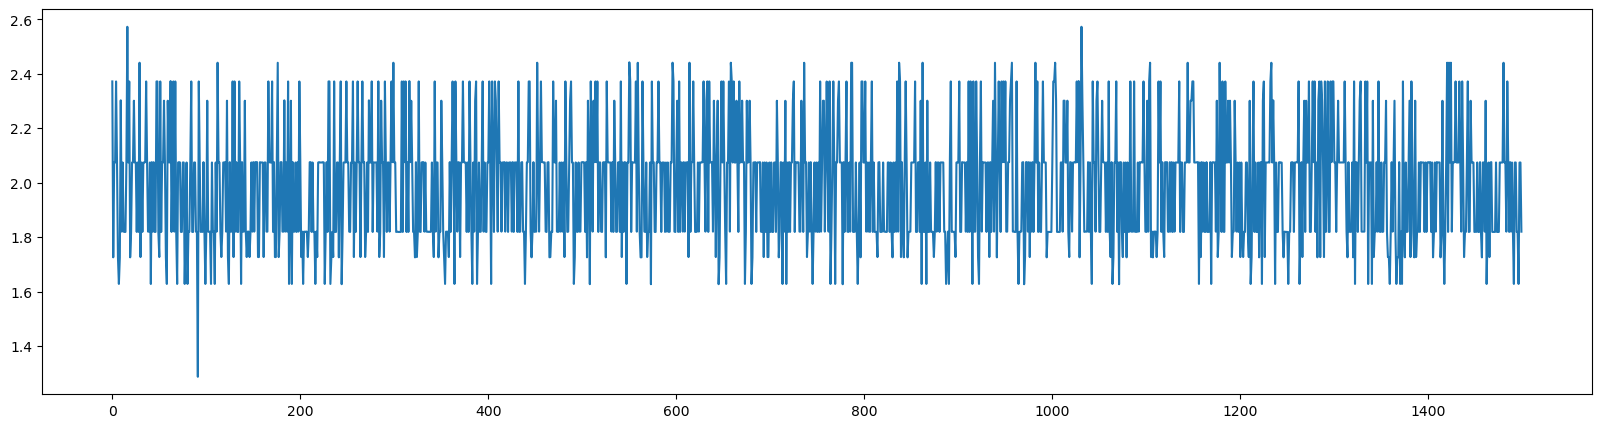

In [67]:
# 绘制一个子载波的CSI幅度随时间的变化
%matplotlib inline
plt.figure(figsize=(20, 5))
plt.plot(np.abs(CSI[0, 0, 0, :]))
plt.show()


In [68]:
# Perform Hampel filtering on the time domain of CSI
CSI_hampel = np.zeros((Nrx, Ntx, Nsc, Nt), dtype=np.complex64)
for rx in range(Nrx):
    for tx in range(Ntx):
        for sc in range(Nsc):
            # CSI_hampel_r = pd.Series(CSI[rx][tx][sc].real)
            # CSI_hampel_i = pd.Series(CSI[rx][tx][sc].imag)
            # CSI_hampel_r = hampel(CSI_hampel_r, window_size=5, n=3, imputation=True)
            # CSI_hampel_i = hampel(CSI_hampel_i, window_size=5, n=3, imputation=True)
            # CSI_hampel[rx][tx][sc] = CSI_hampel_r + 1j * CSI_hampel_i
            CSI_pd = pd.Series(np.abs(CSI[rx][tx][sc]))
            CSI_hampel[rx][tx][sc] = hampel(CSI_pd, window_size=5, n=3, imputation=True)

In [69]:
# savgol_filter滤波
CSI_savgol = np.zeros((Nrx, Ntx, Nsc, Nt), dtype=np.complex64)
for rx in range(Nrx):
    for tx in range(Ntx):
        for sc in range(Nsc):
            CSI_savgol[rx][tx][sc] = savgol_filter(np.abs(CSI[rx][tx][sc]), 8, 7) # 用Savitzky-Golay滤波器去噪


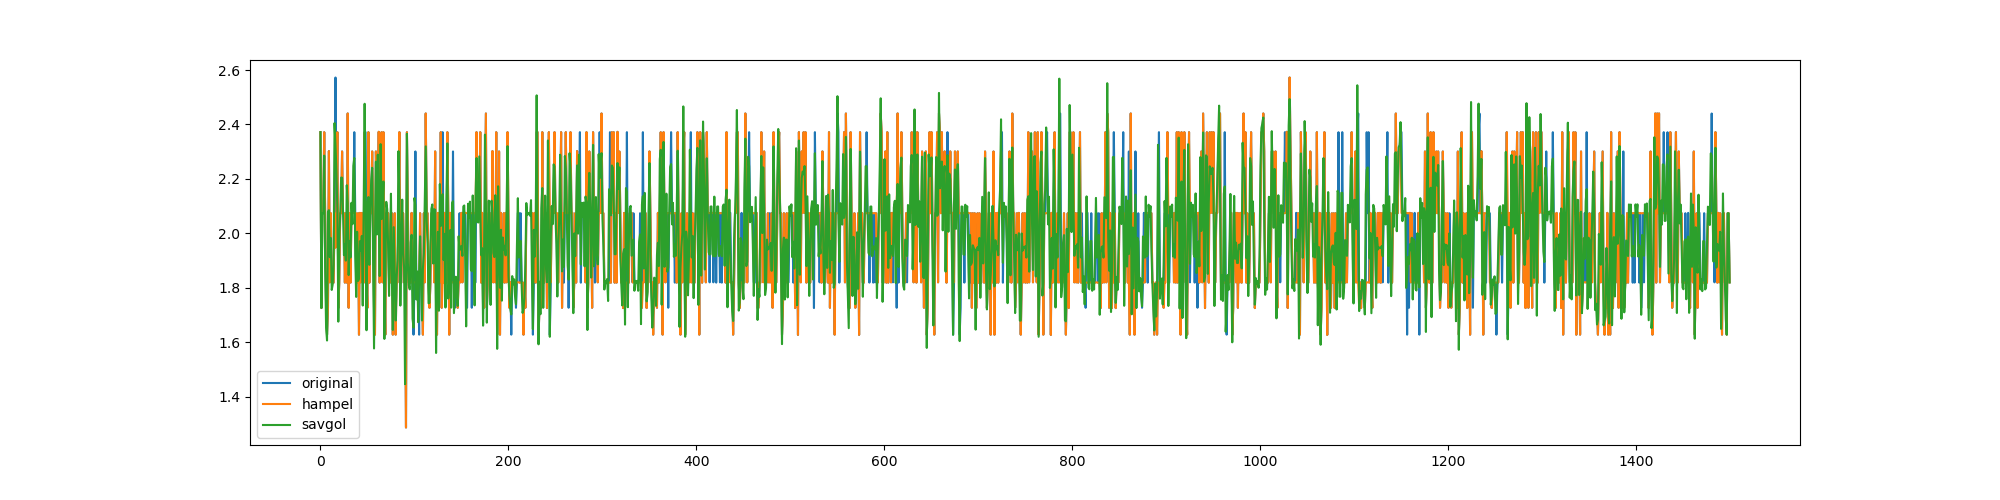

In [70]:
%matplotlib widget
# 比较滤波前、hamper滤波后、savgol滤波后的CSI幅度随时间的变化
plt.figure(figsize=(20, 5))
plt.plot(np.abs(CSI[0, 0, 0, :]), label='original')
plt.plot(np.abs(CSI_hampel[0, 0, 0, :]), label='hampel')
plt.plot(np.abs(CSI_savgol[0, 0, 0, :]), label='savgol')
plt.legend()
plt.show()

In [71]:
# 再进行滑动平均滤波
def np_move_avg(a,n,mode="same"):
    return(np.convolve(a, np.ones((n,))/n, mode=mode))
CSI_avg_hampel = np.zeros((Nrx, Ntx, Nsc, Nt), dtype=np.complex64)
CSI_avg_savgol = np.zeros((Nrx, Ntx, Nsc, Nt), dtype=np.complex64)
n = 8
for rx in range(Nrx):
    for tx in range(Ntx):
        for sc in range(Nsc):
            CSI_avg_hampel[rx][tx][sc] = np_move_avg(CSI_hampel[rx][tx][sc], n, mode="same")
            CSI_avg_savgol[rx][tx][sc] = np_move_avg(CSI_savgol[rx][tx][sc], n, mode="same")


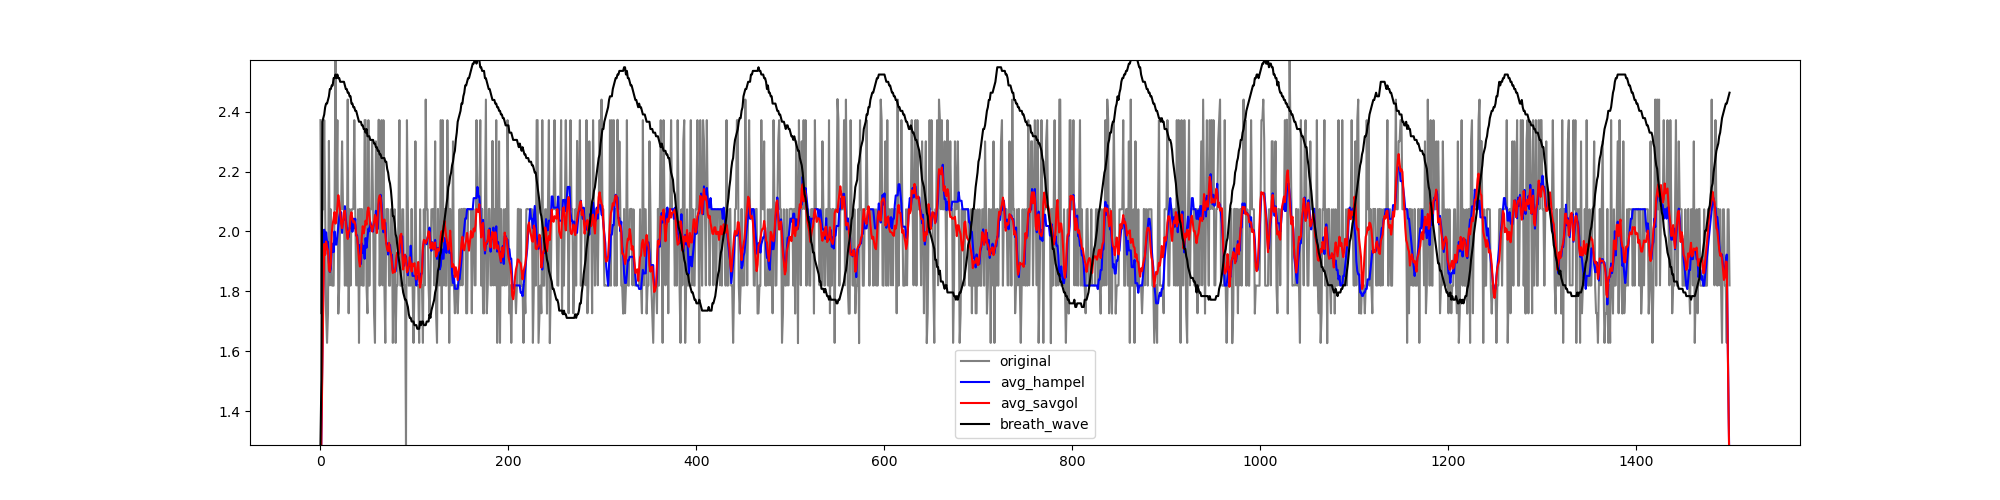

In [79]:
# 比较滤波前、滑动平均滤波后的CSI幅度随时间的变化
plt.figure(figsize=(20, 5))
plt.plot(np.abs(CSI[0, 0, 0, :]), label='original', color='gray')
plt.plot(np.abs(CSI_avg_hampel[0, 0, 0, :]), label='avg_hampel', color='blue')
plt.plot(np.abs(CSI_avg_savgol[0, 0, 0, :]), label='avg_savgol', color='red')
# 设置y轴范围
CSI_min = np.min(np.abs(CSI[0, 0, 0, :]))
CSI_max = np.max(np.abs(CSI[0, 0, 0, :]))
plt.ylim(CSI_min, CSI_max)
scaler = MinMaxScaler(feature_range=(CSI_min, CSI_max))
Wave = scaler.fit_transform(Wave.reshape(-1, 1)).reshape(-1)
plt.plot(Wave, label='breath_wave', color='black')
plt.legend()
plt.show()

In [73]:
H = np.zeros((Nrx, Ntx, Nsc, dftSize), dtype = complex) # 用于存储DFT结果

m, n = np.meshgrid(np.arange(Nt), np.arange(dftSize))
Wdft = np.exp(-1j * 2 * np.pi * m * n / Ndft) # dft 矩阵

# print(Wdft)

print(Wdft.shape)
print(CSI[0][0][0].shape)

Hs = np.zeros((dftSize), dtype = complex)

for rx in range(Nrx):
    for tx in range(Ntx):
        for sc in range(Nsc):
            H[rx][tx][sc] = Wdft @ CSI_avg_savgol[rx][tx][sc]
            Hs += H[rx][tx][sc]
                # CSI[rx][tx][sc][t] = CSI[rx][tx][sc][t] * np.exp(-1j * 2 * np.pi * fstart * t / 312.5)
                # CSI[rx][tx][sc][t] = CSI[rx][tx][sc][t] * np.exp(-1j * 2 * np.pi * fend * t / 312.5)

# H000 = np.fft.fft(CSI[0][0][0], Ndft)
# for rx in range(Nrx):
#     for tx in range(Ntx):
#         for sc in range(Nsc):
#             H[rx][tx][sc] = np.fft.fft(CSI[rx][tx][sc], Ndft)
            # CSI[rx][tx][sc][t] = CSI[rx][tx][sc][t] * np.exp(-1j * 2 * np.pi * fstart * t / 312.5)
            # CSI[rx][tx][sc][t] = CSI[rx][tx][sc][t] * np.exp(-1j * 2 * np.pi * fend * t / 312.5)


(419, 1500)
(1500,)


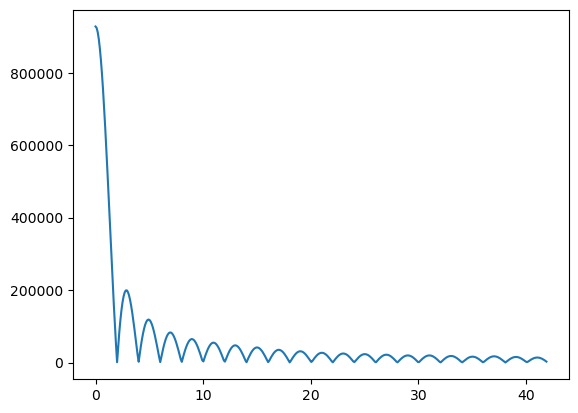

In [74]:
%matplotlib inline

# breathStartHz = 0.16
# breathEndHz = 0.5

# plt.plot(np.abs(H000[:30]))
# plt.plot(np.arange(0, breathEnd, breathEnd / dftSize) * 60, np.abs(H[0][0][2]))
plt.plot(np.arange(0, breathEnd, breathEnd / dftSize) * 60, np.abs(Hs))

# print(np.arange(0, breathEnd, breathEnd / dftSize) * 60)

[ 50  69  89 110 130 150 169 190 210 229 249 269 289 310 330 350 369 389
 410]
[ 0  1  2  3  4  5  7  6  8  9 10 11 12 13 14 15 18 17 16]
[ 50  69  89 110 130 150 190 169 210 229 249 269 289 310 330 350 410 389
 369]
[146047.44543608 105455.82264346  79803.2942453   70130.06089216
  54513.68090918  47208.98680592  41473.81999637  42628.83157761
  32735.42480989  29544.61395492  28255.044956    27833.78531961
  26529.21230435  25086.95221675  22132.58924923  21245.94869727
  16406.98747705  20176.1000276   21146.80721299]
[ 5.   6.9  8.9 11.  13.  15.  19.  16.9 21.  22.9 24.9 26.9 28.9 31.
 33.  35.  41.  38.9 36.9]


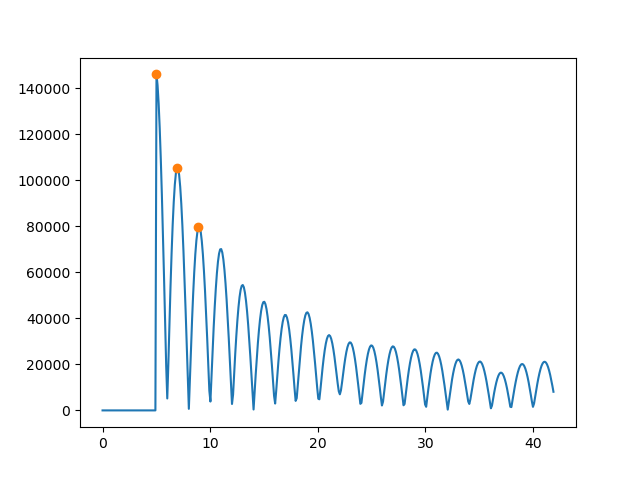

No such comm: 70f6714b97244fceac6443a0414c3070


[ 50  69  90 110 130 150 170 190 210 230 250 270 290 310 330 350 370 390
 410]
[ 0  1  2  3  4  5  7  6  8  9 10 11 12 13 14 15 18 17 16]
[ 50  69  90 110 130 150 190 170 210 230 250 270 290 310 330 350 410 390
 370]
[146011.50884357 105156.45650853  79655.48958793  70035.60110114
  54428.01612869  47107.29362277  41314.54923348  42421.44676197
  32605.30396948  29381.66186803  27931.49777223  27456.50588863
  26226.96148872  24811.03205325  21886.34914395  20979.23456161
  16237.62084261  19587.70838504  20639.20540221]
[ 5.   6.9  9.  11.  13.  15.  19.  17.  21.  23.  25.  27.  29.  31.
 33.  35.  41.  39.  37. ]


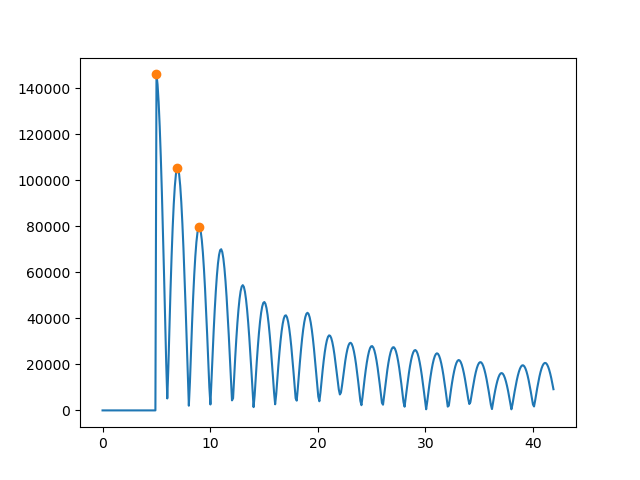

No such comm: e2341b35ca304662bef058b12e500e79


[ 50  69  89 110 130 150 169 190 210 229 249 269 289 309 330 350 369 389
 409]
[ 0  1  2  3  4  5  7  6  8  9 10 11 12 13 14 15 18 17 16]
[ 50  69  89 110 130 150 190 169 210 229 249 269 289 309 330 350 409 389
 369]
[146049.8932073  105585.89392434  79935.21107168  70138.93233244
  54519.39292909  47218.04335616  41604.99751416  42664.52243268
  32746.22448483  29667.93982027  28388.2912528   27978.08958071
  26678.36182108  25153.26526028  22156.01035452  21264.33593119
  16512.63230963  20344.401947    21236.37642955]
[ 5.   6.9  8.9 11.  13.  15.  19.  16.9 21.  22.9 24.9 26.9 28.9 30.9
 33.  35.  40.9 38.9 36.9]


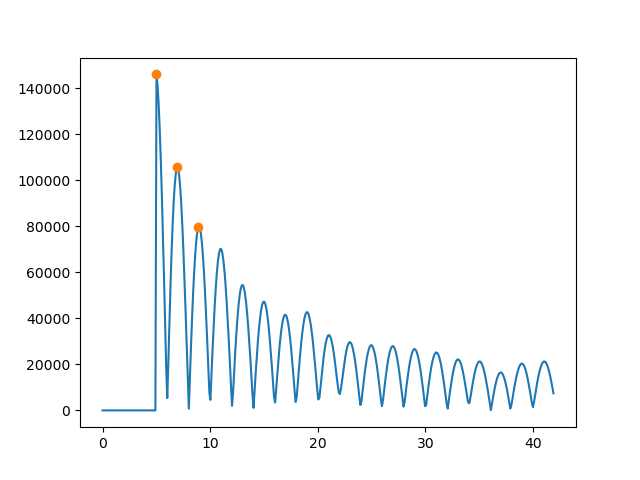

No such comm: bd23197a896b43d5b1b411c85aaccd45


[ 50  69  89 109 130 149 169 189 210 229 249 269 289 309 329 349 369 389
 409]
[ 0  1  2  3  4  5  7  6  8  9 10 11 12 13 14 18 15 17 16]
[ 50  69  89 109 130 149 189 169 210 229 249 269 289 309 329 409 349 389
 369]
[146047.43843326 105644.87785017  79994.04691014  70160.66619462
  54513.34260074  47246.98731176  41658.1763684   42666.34550657
  32738.25670498  29714.14417359  28436.92377315  28028.18190705
  26728.09166628  25205.03940004  22182.01366489  21291.51774239
  16547.3251453   20394.08225146  21297.17324682]
[ 5.   6.9  8.9 10.9 13.  14.9 18.9 16.9 21.  22.9 24.9 26.9 28.9 30.9
 32.9 40.9 34.9 38.9 36.9]


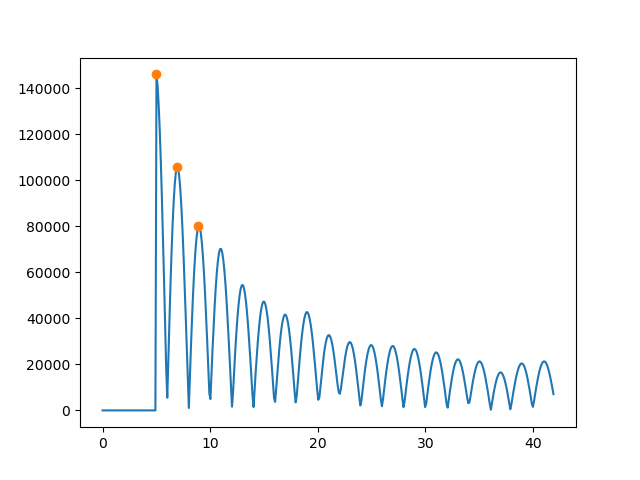

No such comm: 9d2172f2a27548d9b55313082767b78a


[ 50  69  89 110 130 150 169 190 210 229 249 269 289 310 330 350 369 389
 410]
[ 0  1  2  3  4  5  7  6  8  9 10 11 12 13 14 15 18 17 16]
[ 50  69  89 110 130 150 190 169 210 229 249 269 289 310 330 350 410 389
 369]
[146047.44543608 105455.82264346  79803.2942453   70130.06089216
  54513.68090918  47208.98680592  41473.81999637  42628.83157761
  32735.42480989  29544.61395492  28255.044956    27833.78531961
  26529.21230435  25086.95221675  22132.58924923  21245.94869727
  16406.98747705  20176.1000276   21146.80721299]
[ 5.   6.9  8.9 11.  13.  15.  19.  16.9 21.  22.9 24.9 26.9 28.9 31.
 33.  35.  41.  38.9 36.9]


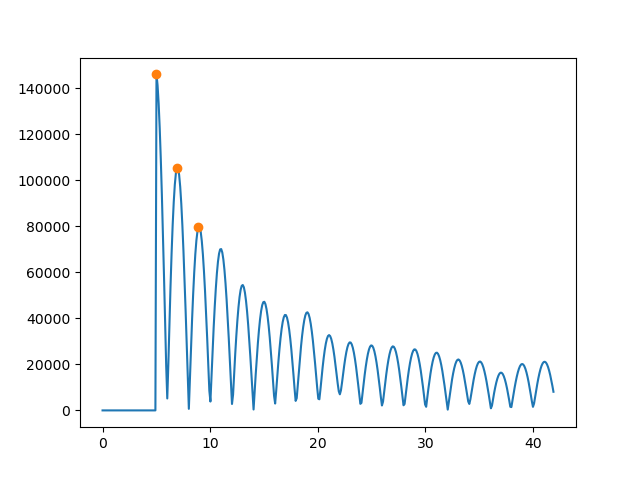

No such comm: 46ab79cb958f4e51965839d025eae54a


[ 50  69  89 109 129 150 170 190 210 230 250 270 290 309 330 349 370 390
 410]
[ 0  1  2  3  4  5  6  7  8  9 10 11 13 12 14 16 15 17 18]
[ 50  69  89 109 129 150 170 190 210 230 250 270 309 290 330 370 349 390
 410]
[117867.42866949  83234.79842272  65014.32860712  55087.71935321
  47607.38644153  41878.09995539  35373.10966986  31312.1530992
  27162.49956661  25116.17282825  23365.19416218  21845.82871944
  19819.87165664  19825.9609607   18307.10853208  16410.77219278
  17380.37625092  15638.30065907  14045.99687048]
[ 5.   6.9  8.9 10.9 12.9 15.  17.  19.  21.  23.  25.  27.  30.9 29.
 33.  37.  34.9 39.  41. ]


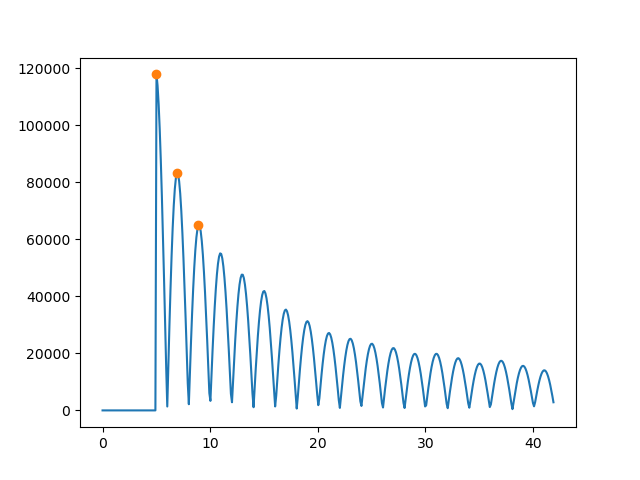

In [75]:
%matplotlib widget
filteredHs = np.zeros_like(Hs)
minBPM, maxBPM = 5, 50
minIndex, maxIndex = int(minBPM / BPMresol), int(maxBPM / BPMresol)

filteredHs[minIndex: maxIndex] = Hs[minIndex:maxIndex]

plt.plot(np.arange(0, breathEnd, breathEnd / dftSize) * 60, np.abs(filteredHs))
np.argmax(np.abs(filteredHs)) * BPMresol
idx, _ = find_peaks(np.abs(filteredHs), height = 0.1, distance = 1)
# 绘制峰值位置
# plt.plot(idx * BPMresol, np.abs(filteredHs[idx]), "x")

highestPeak = np.argsort(-np.abs(filteredHs[idx]))
# 绘制最大峰值位置
plt.plot(idx[highestPeak[:3]] * BPMresol, np.abs(filteredHs[idx[highestPeak[:3]]]), "o")
print(idx)
print(highestPeak)
print(idx[highestPeak])
print(np.abs(filteredHs[idx]))
print(idx[highestPeak] * BPMresol)

[ 50  69  89 110 130 150 169 190 210 229 249 269 289 310 330 350 369 389
 410]
[ 0  1  2  3  4  5  7  6  8  9 10 11 12 13 14 15 18 17 16]
[ 50  69  89 110 130 150 190 169 210 229 249 269 289 310 330 350 410 389
 369]
[146047.44543608 105455.82264346  79803.2942453   70130.06089216
  54513.68090918  47208.98680592  41473.81999637  42628.83157761
  32735.42480989  29544.61395492  28255.044956    27833.78531961
  26529.21230435  25086.95221675  22132.58924923  21245.94869727
  16406.98747705  20176.1000276   21146.80721299]
[ 5.   6.9  8.9 11.  13.  15.  19.  16.9 21.  22.9 24.9 26.9 28.9 31.
 33.  35.  41.  38.9 36.9]


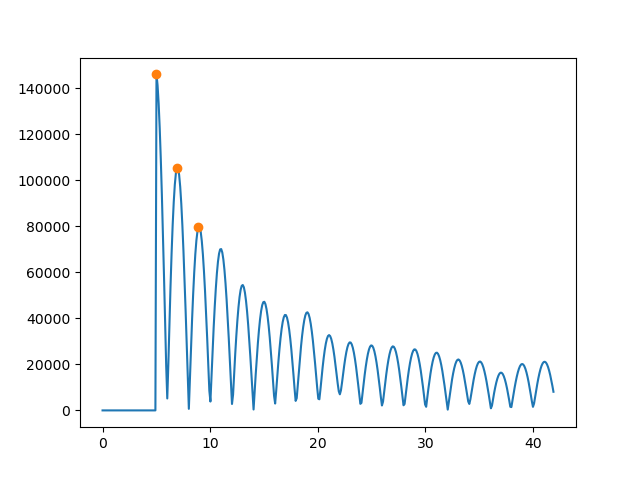

No such comm: 70f6714b97244fceac6443a0414c3070


[ 50  69  90 110 130 150 170 190 210 230 250 270 290 310 330 350 370 390
 410]
[ 0  1  2  3  4  5  7  6  8  9 10 11 12 13 14 15 18 17 16]
[ 50  69  90 110 130 150 190 170 210 230 250 270 290 310 330 350 410 390
 370]
[146011.50884357 105156.45650853  79655.48958793  70035.60110114
  54428.01612869  47107.29362277  41314.54923348  42421.44676197
  32605.30396948  29381.66186803  27931.49777223  27456.50588863
  26226.96148872  24811.03205325  21886.34914395  20979.23456161
  16237.62084261  19587.70838504  20639.20540221]
[ 5.   6.9  9.  11.  13.  15.  19.  17.  21.  23.  25.  27.  29.  31.
 33.  35.  41.  39.  37. ]


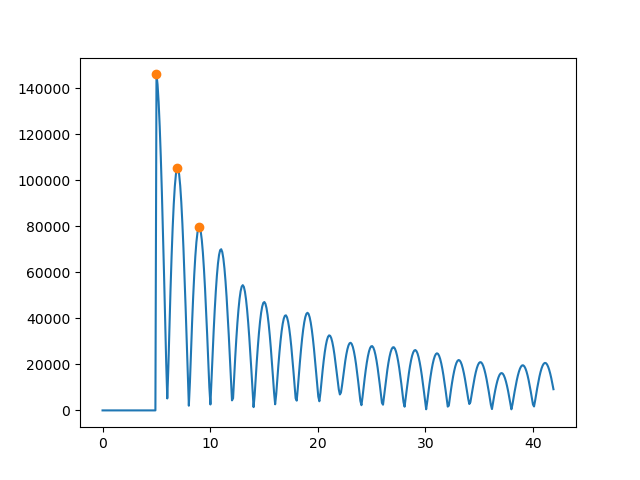

No such comm: e2341b35ca304662bef058b12e500e79


[ 50  69  89 110 130 150 169 190 210 229 249 269 289 309 330 350 369 389
 409]
[ 0  1  2  3  4  5  7  6  8  9 10 11 12 13 14 15 18 17 16]
[ 50  69  89 110 130 150 190 169 210 229 249 269 289 309 330 350 409 389
 369]
[146049.8932073  105585.89392434  79935.21107168  70138.93233244
  54519.39292909  47218.04335616  41604.99751416  42664.52243268
  32746.22448483  29667.93982027  28388.2912528   27978.08958071
  26678.36182108  25153.26526028  22156.01035452  21264.33593119
  16512.63230963  20344.401947    21236.37642955]
[ 5.   6.9  8.9 11.  13.  15.  19.  16.9 21.  22.9 24.9 26.9 28.9 30.9
 33.  35.  40.9 38.9 36.9]


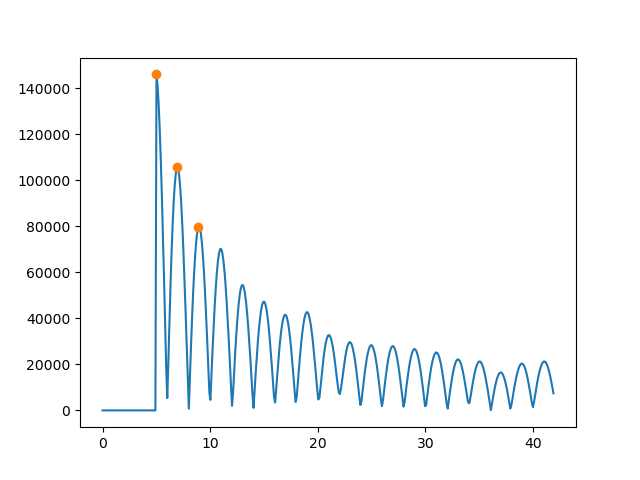

No such comm: bd23197a896b43d5b1b411c85aaccd45


[ 50  69  89 109 130 149 169 189 210 229 249 269 289 309 329 349 369 389
 409]
[ 0  1  2  3  4  5  7  6  8  9 10 11 12 13 14 18 15 17 16]
[ 50  69  89 109 130 149 189 169 210 229 249 269 289 309 329 409 349 389
 369]
[146047.43843326 105644.87785017  79994.04691014  70160.66619462
  54513.34260074  47246.98731176  41658.1763684   42666.34550657
  32738.25670498  29714.14417359  28436.92377315  28028.18190705
  26728.09166628  25205.03940004  22182.01366489  21291.51774239
  16547.3251453   20394.08225146  21297.17324682]
[ 5.   6.9  8.9 10.9 13.  14.9 18.9 16.9 21.  22.9 24.9 26.9 28.9 30.9
 32.9 40.9 34.9 38.9 36.9]


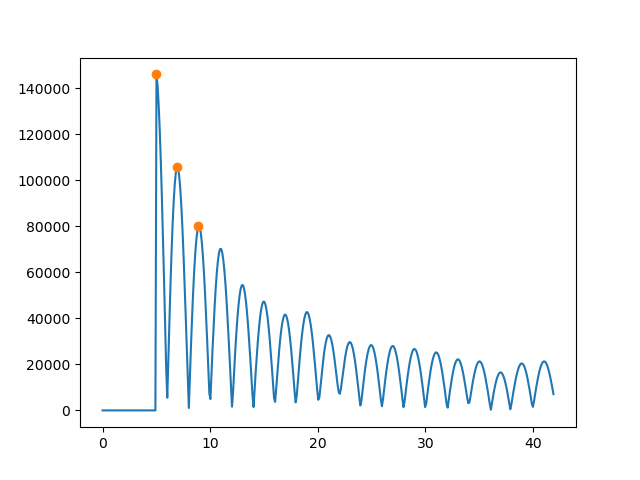

No such comm: 9d2172f2a27548d9b55313082767b78a


[ 50  69  89 110 130 150 169 190 210 229 249 269 289 310 330 350 369 389
 410]
[ 0  1  2  3  4  5  7  6  8  9 10 11 12 13 14 15 18 17 16]
[ 50  69  89 110 130 150 190 169 210 229 249 269 289 310 330 350 410 389
 369]
[146047.44543608 105455.82264346  79803.2942453   70130.06089216
  54513.68090918  47208.98680592  41473.81999637  42628.83157761
  32735.42480989  29544.61395492  28255.044956    27833.78531961
  26529.21230435  25086.95221675  22132.58924923  21245.94869727
  16406.98747705  20176.1000276   21146.80721299]
[ 5.   6.9  8.9 11.  13.  15.  19.  16.9 21.  22.9 24.9 26.9 28.9 31.
 33.  35.  41.  38.9 36.9]


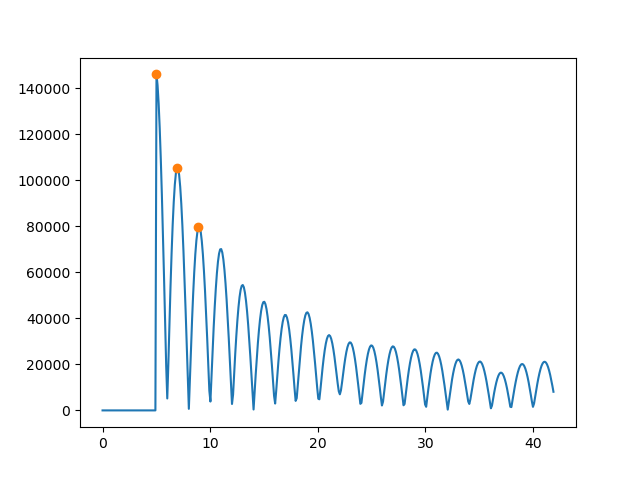

No such comm: 46ab79cb958f4e51965839d025eae54a


[ 50  69  89 109 129 150 170 190 210 230 250 270 290 309 330 349 370 390
 410]
[ 0  1  2  3  4  5  6  7  8  9 10 11 13 12 14 16 15 17 18]
[ 50  69  89 109 129 150 170 190 210 230 250 270 309 290 330 370 349 390
 410]
[117867.42866949  83234.79842272  65014.32860712  55087.71935321
  47607.38644153  41878.09995539  35373.10966986  31312.1530992
  27162.49956661  25116.17282825  23365.19416218  21845.82871944
  19819.87165664  19825.9609607   18307.10853208  16410.77219278
  17380.37625092  15638.30065907  14045.99687048]
[ 5.   6.9  8.9 10.9 12.9 15.  17.  19.  21.  23.  25.  27.  30.9 29.
 33.  37.  34.9 39.  41. ]


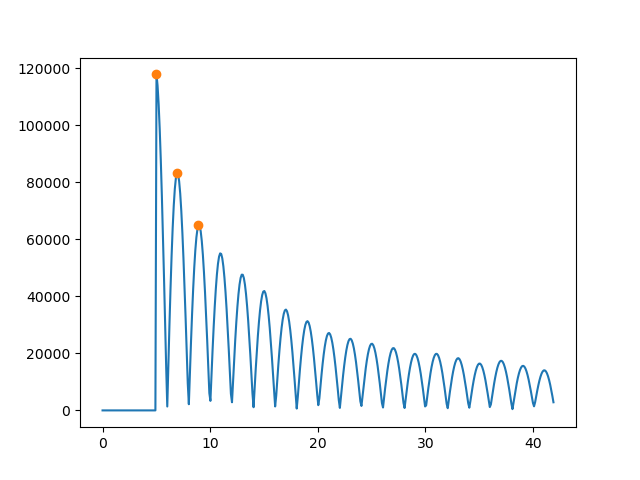

In [ ]:
%matplotlib widget
filteredHs = np.zeros_like(Hs)
minBPM, maxBPM = 5, 50
minIndex, maxIndex = int(minBPM / BPMresol), int(maxBPM / BPMresol)

filteredHs[minIndex: maxIndex] = Hs[minIndex:maxIndex]

plt.plot(np.arange(0, breathEnd, breathEnd / dftSize) * 60, np.abs(filteredHs))
np.argmax(np.abs(filteredHs)) * BPMresol
idx, _ = find_peaks(np.abs(filteredHs), height = 0.1, distance = 1)
# 绘制峰值位置
# plt.plot(idx * BPMresol, np.abs(filteredHs[idx]), "x")

highestPeak = np.argsort(-np.abs(filteredHs[idx]))
# 绘制最大峰值位置
plt.plot(idx[highestPeak[:3]] * BPMresol, np.abs(filteredHs[idx[highestPeak[:3]]]), "o")
print(idx)
print(highestPeak)
print(idx[highestPeak])
print(np.abs(filteredHs[idx]))
print(idx[highestPeak] * BPMresol)

In [76]:
%matplotlib widget
filteredHs = np.zeros_like(Hs)
minBPM, maxBPM = 10, 30
minIndex, maxIndex = int(minBPM / BPMresol), int(maxBPM / BPMresol)

Amp = 0
WeightedSum = 0

for rx in range(Nrx):
    for tx in range(Ntx):
        for sc in range(Nsc):
            filteredHs = np.zeros_like(Hs, dtype=np.float64)
            filteredHs[minIndex: maxIndex] = np.abs(H[rx][tx][sc][minIndex:maxIndex])
            idx, _ = find_peaks(filteredHs, height = 0.1, distance = 1)
            highestPeak = np.argsort(-filteredHs[idx])
            Amp += filteredHs[idx[highestPeak[0]]]
            WeightedSum += filteredHs[idx[highestPeak[0]]] * idx[highestPeak[0]]
            Amp += filteredHs[idx[highestPeak[1]]]
            WeightedSum += filteredHs[idx[highestPeak[1]]] * idx[highestPeak[1]]
            Amp += filteredHs[idx[highestPeak[2]]]
            WeightedSum += filteredHs[idx[highestPeak[2]]] * idx[highestPeak[2]]

f = WeightedSum / Amp
f * BPMresol

# filteredHs[minIndex: maxIndex] = H[0][0][0][minIndex:maxIndex]

# plt.plot(np.arange(0, breathEnd, breathEnd / dftSize) * 60, np.abs(filteredHs))
# np.argmax(np.abs(filteredHs)) * BPMresol
# idx, _ = find_peaks(np.abs(filteredHs), height = 0.1, distance = 1)

# highestPeak = np.argsort(-np.abs(filteredHs[idx]))

# print(idx[highestPeak] * BPMresol)

12.757859299007784

-8.931566789112155

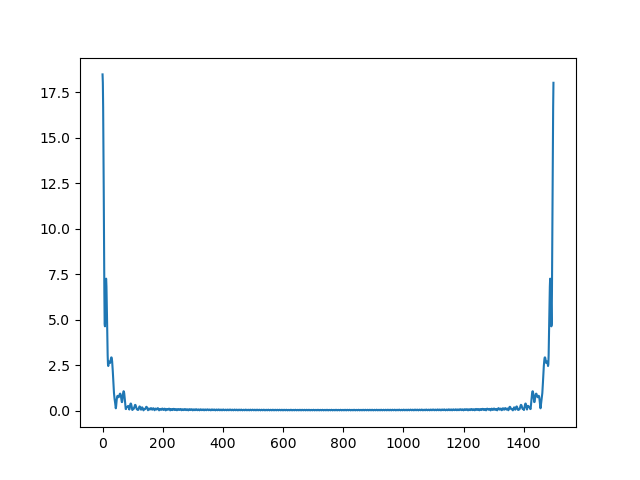

No such comm: 0019923e17ef4273bfa6b119d4e38185


-25.51328065833881

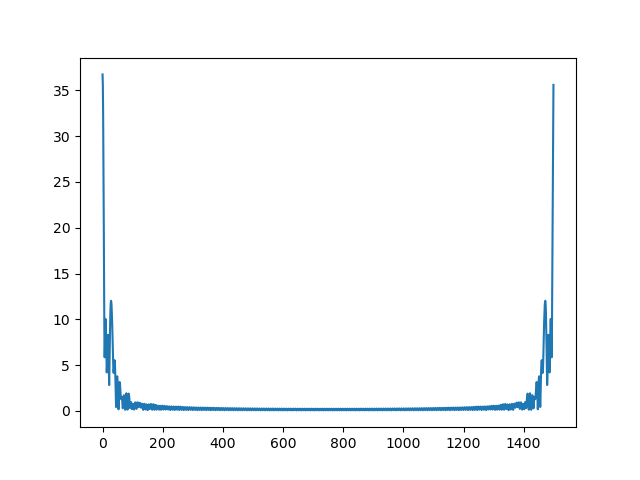

No such comm: fb6bc83de32f4c6f80b5b92ba14be459


-18.300561961043055

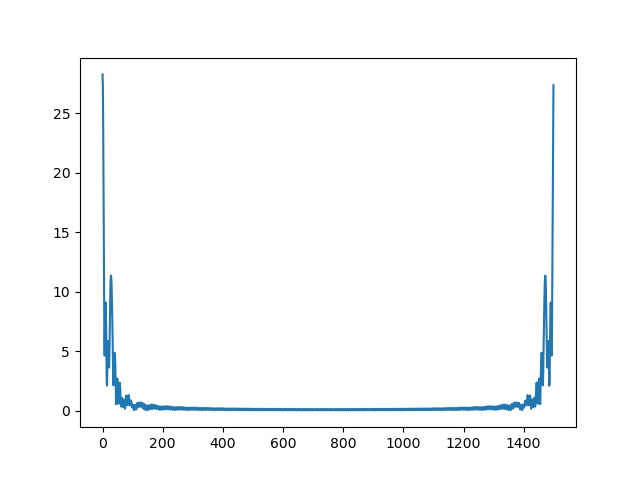

No such comm: 1488b821f4704a95aa3044f4fb707646


-20.481111024831936

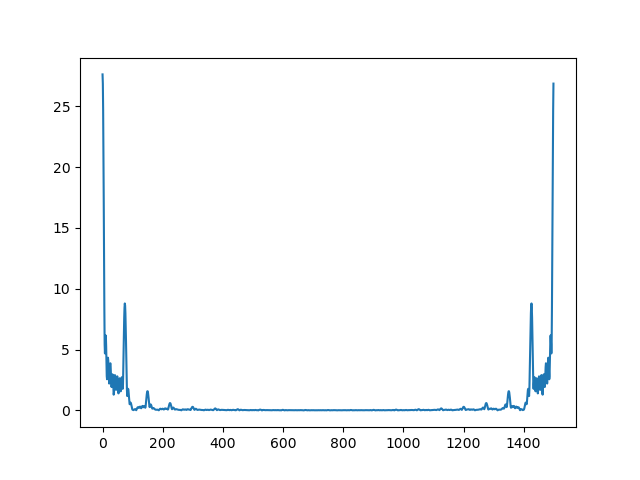

No such comm: 8558652b23b546a6ae24ff6c6c9a2df4


-20.386405627167132

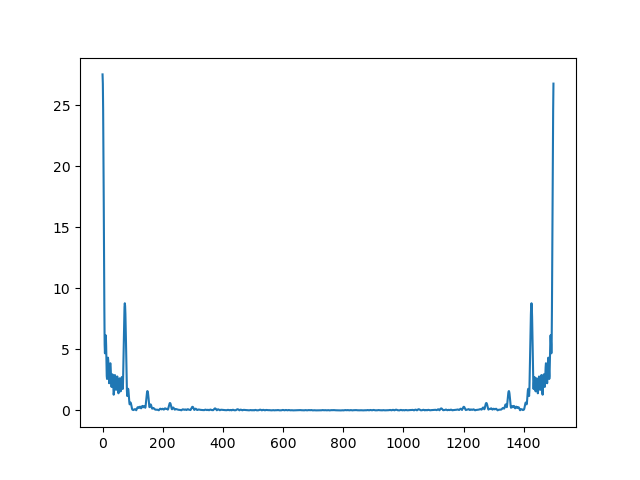

No such comm: 8dd1eec3a7674dbe8542bf9d66de8b8a


-20.501174893170365

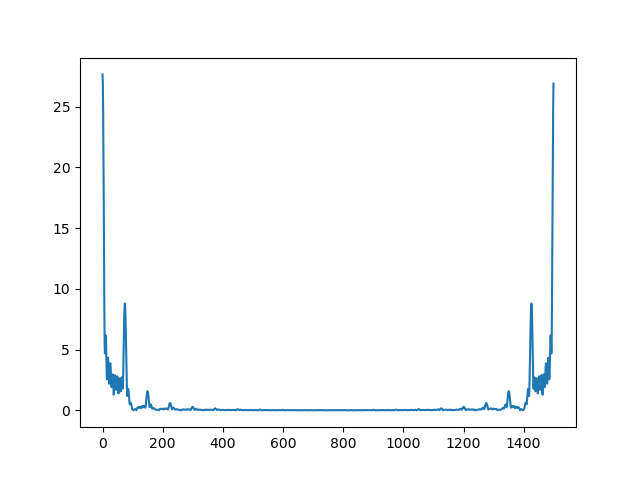

No such comm: 32b21159764045f380eb28bd0591553f


-20.504724525061295

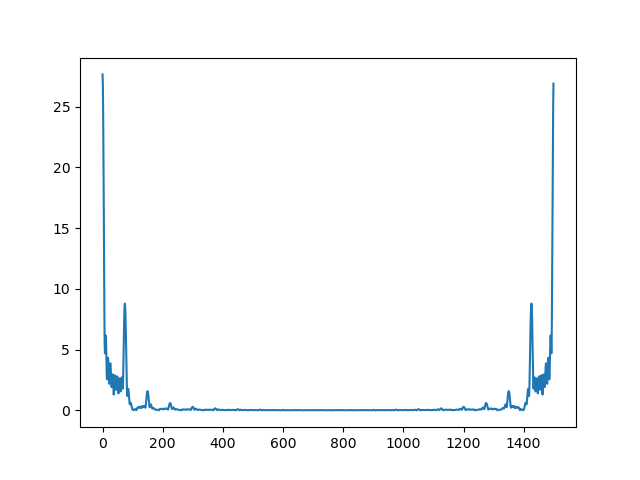

No such comm: abd27989683144edadd85083d07e7d90


-20.481111024831936

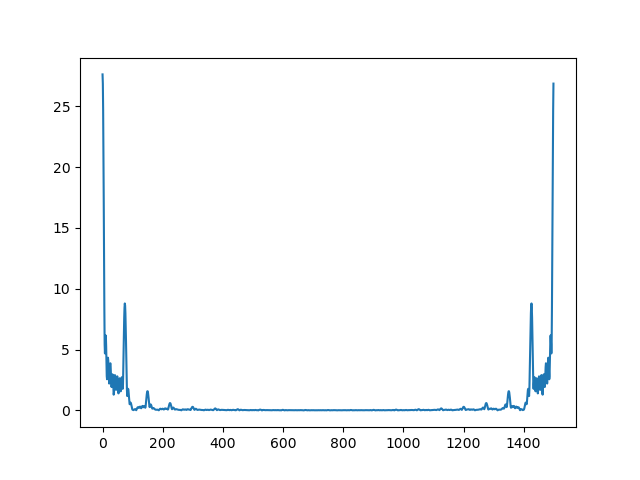

No such comm: 8f6e15763e8646a98500c30028bdb149


-16.782594056928687

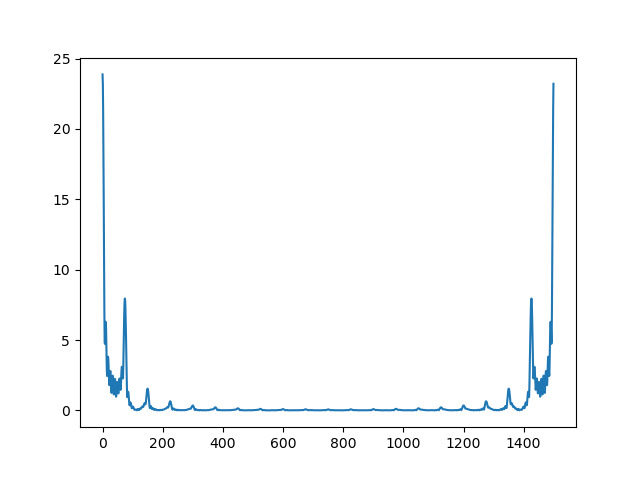

In [77]:
%matplotlib widget
filteredHs
s = np.fft.ifft(filteredHs, Nt)
abss = np.abs(s)
plt.plot(abss)

# get angle of s
angle = np.angle(s)

idx, _ = find_peaks(abss, height = 0.1, distance = 1)
slope = (abss[idx[0]] - abss[0]) / idx[0]
slope / (2 * np.pi) * 60